In [32]:
import pandas as pd
from matplotlib import pyplot as cm
from PIL import Image, ImageDraw, ImageColor
from pathlib import Path


def annotate_image_with_predictions(
    img, predictions, likelihood_threshold, skeleton_color
):
    """
    Annotates an image with dots at specific points.
    Args:
        root_dir (str): Path to the directory containing image files.
        image_path (str): Path to the image file relative to root_dir.
        predictions (pd.Dataframe): A pandas dataframe where index = keypoint
                                    and columns are x, y, likelihood
                                    representing the points.
    """
    draw = ImageDraw.Draw(img, "RGBA")
    dot_color = ImageColor.getrgb(skeleton_color) + (255,)
    skeleton_color = ImageColor.getrgb(skeleton_color) + (128,)

    # Draw dots on the image
    for i, (keypoint, (x, y, likelihood)) in enumerate(predictions.iterrows()):
        # Skip points below the threshold
        if likelihood < likelihood_threshold:
            continue
        draw.ellipse(
            (x - 2, y - 2, x + 2, y + 2), fill=dot_color
        )  # Draw a dot with radius 2

    # TODO read from a file?
    skeleton = [
        ("botBeak", "topBeak"),
        ("topBeak", "topHead"),
        ("topHead", "rightEye"),
        ("topHead", "leftEye"),
        ("topHead", "backHead"),
        ("backHead", "centerBack"),
        ("centerBack", "leftWing"),
        ("centerBack", "rightWing"),
        ("centerBack", "baseTail"),
        ("baseTail", "tipTail"),
        ("centerBack", "leftAnkle"),
        ("centerBack", "rightAnkle"),
        ("centerBack", "centerChes"),
        ("centerBack", "leftNeck"),
        ("centerBack", "rightNeck"),
        ("leftAnkle", "leftFoot"),
        ("rightAnkle", "rightFoot"),
    ]
    for keypoint1, keypoint2 in skeleton:
        pred1 = predictions.loc[keypoint1]
        pred2 = predictions.loc[keypoint2]
        x1, y1, likelihood1 = pred1.x, pred1.y, pred1.likelihood
        x2, y2, likelihood2 = pred2.x, pred2.y, pred2.likelihood
        if min(likelihood1, likelihood2) < likelihood_threshold:
            continue
        draw.line([(x1, y1), (x2, y2)], fill=skeleton_color, width=3)

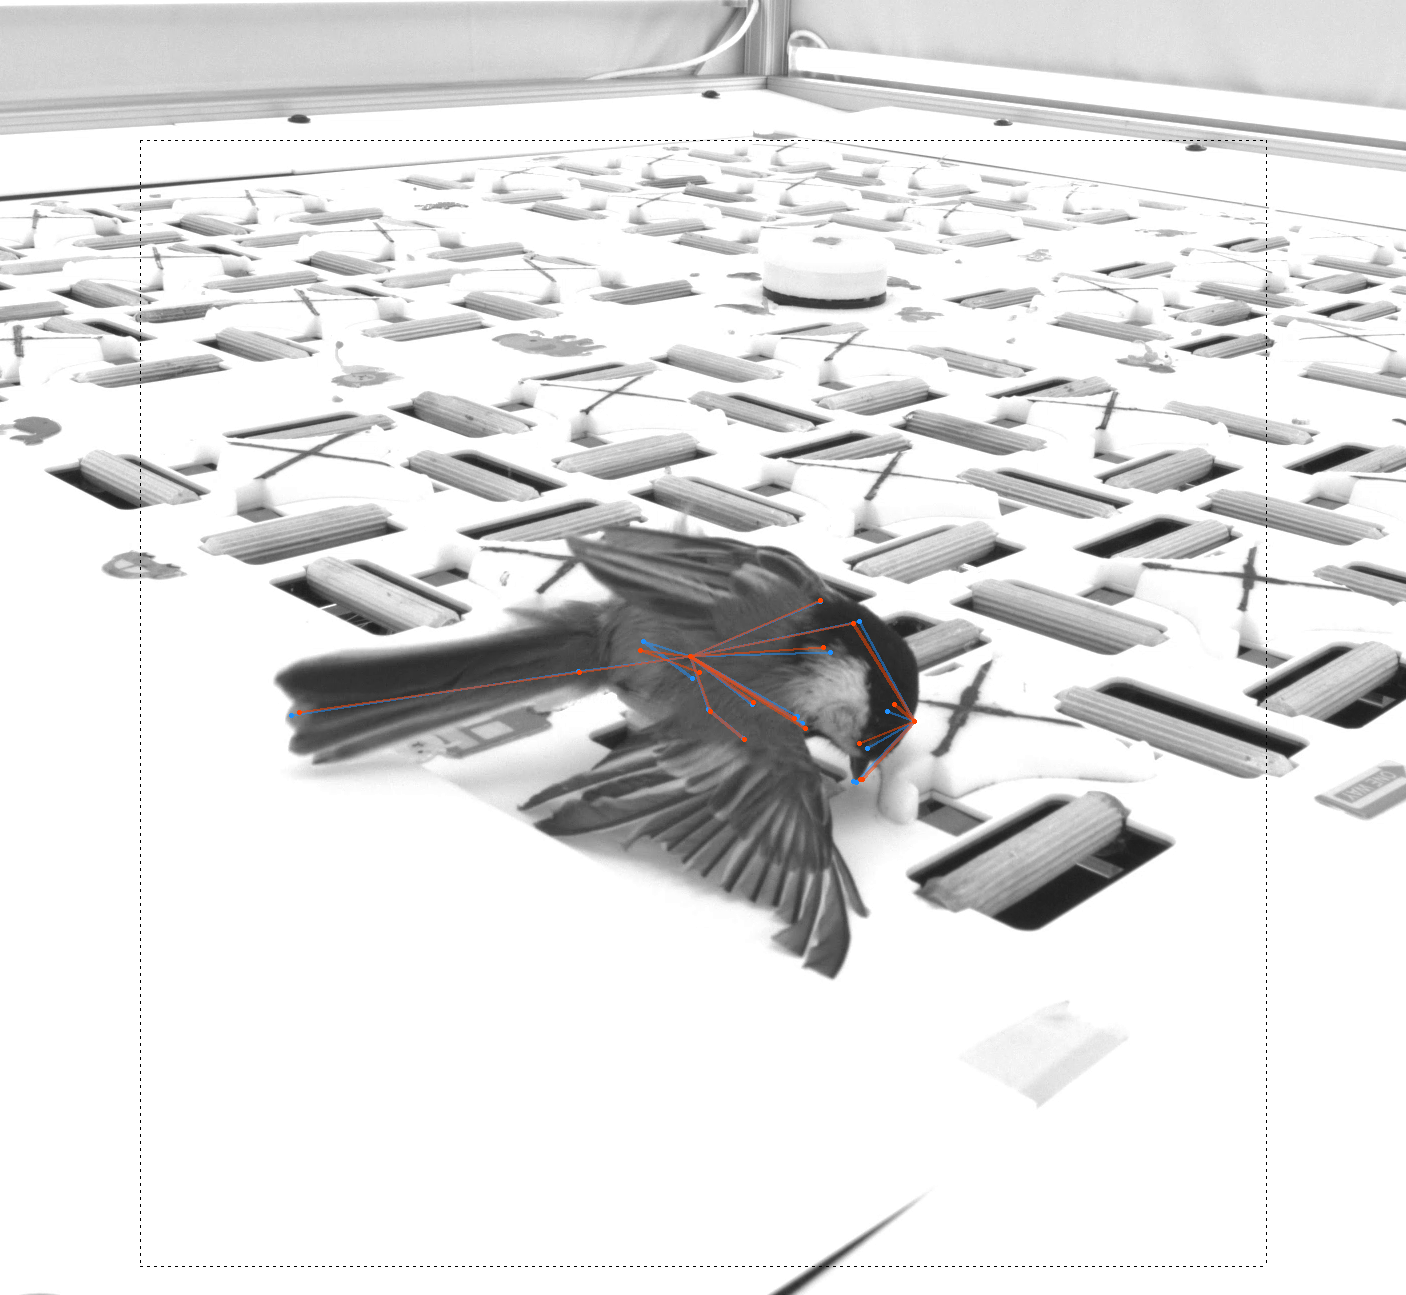

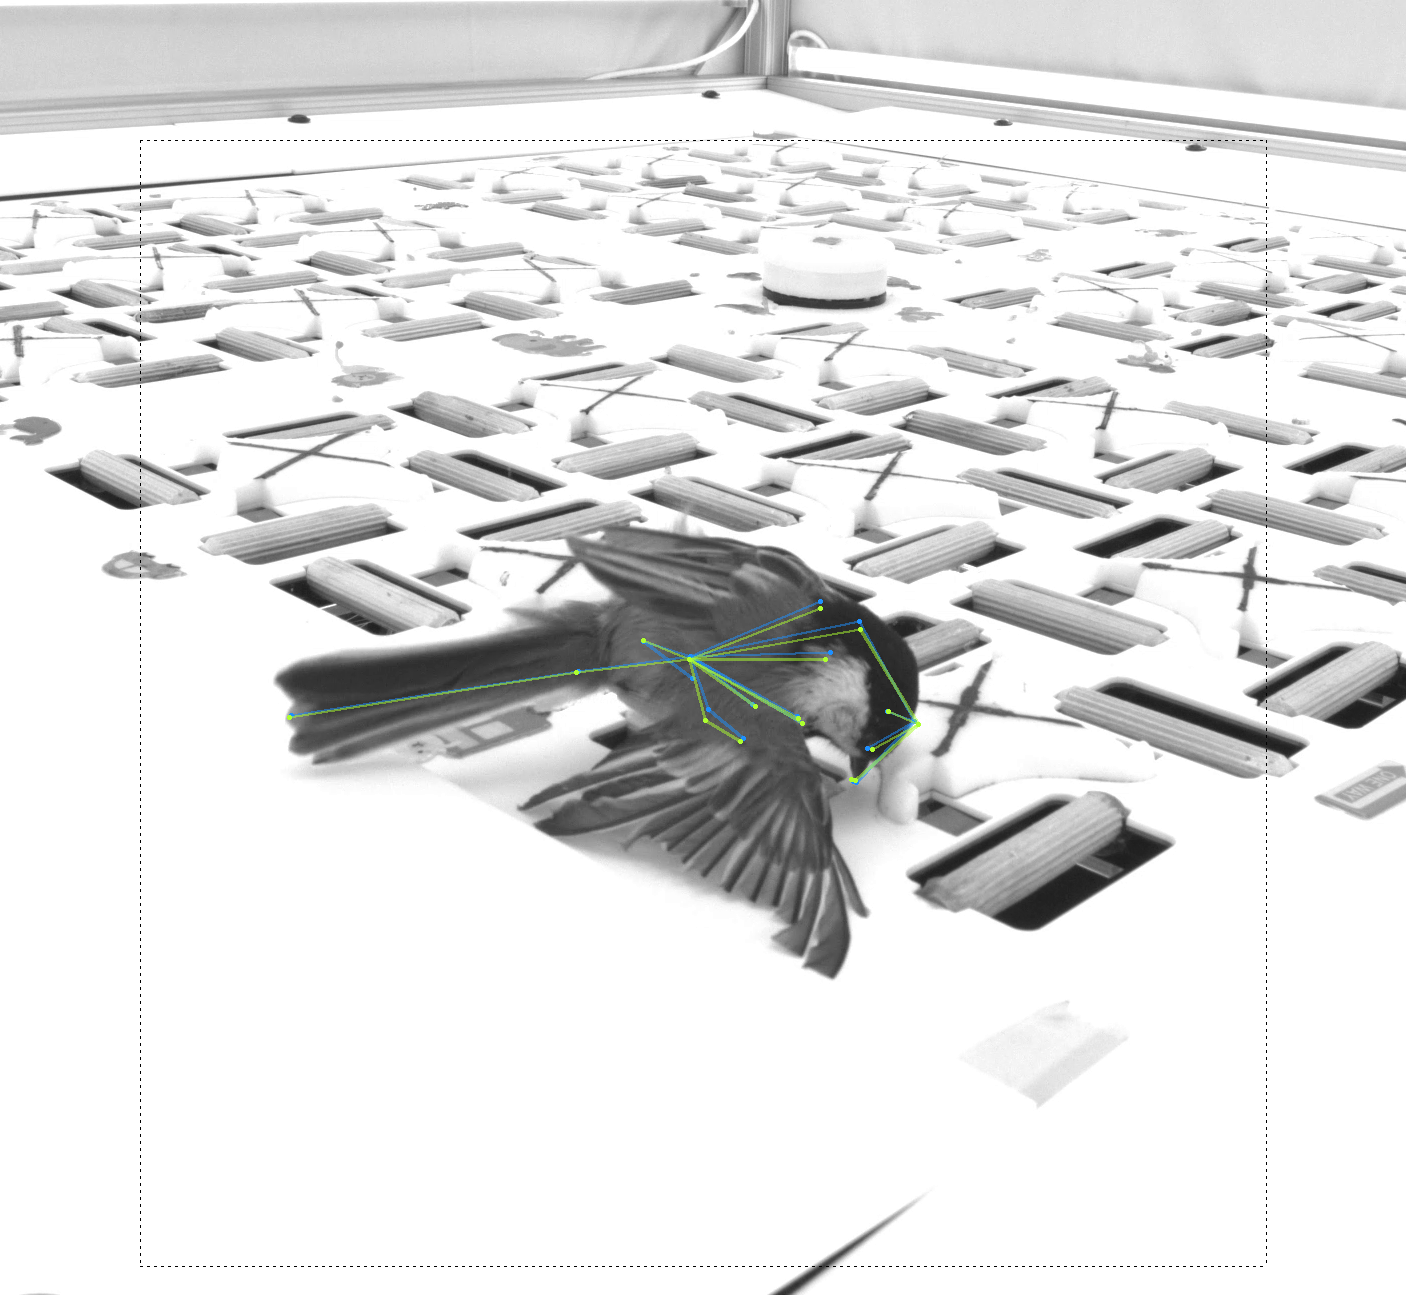

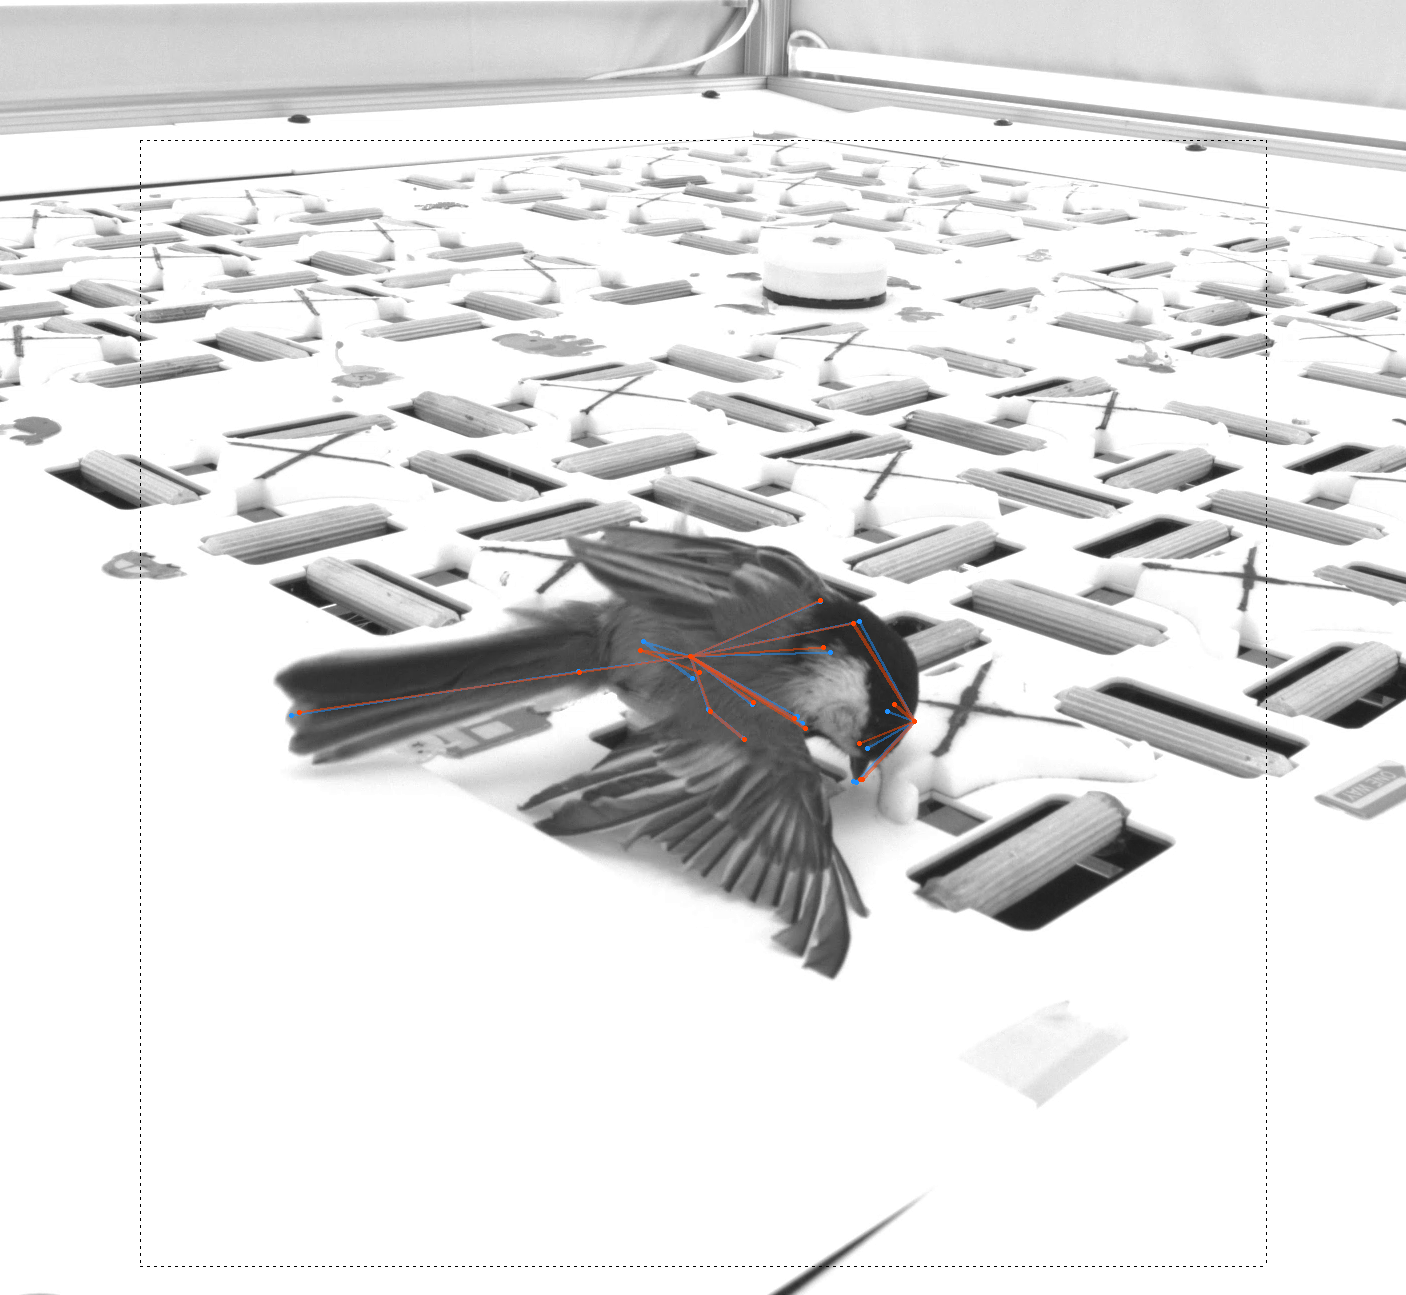

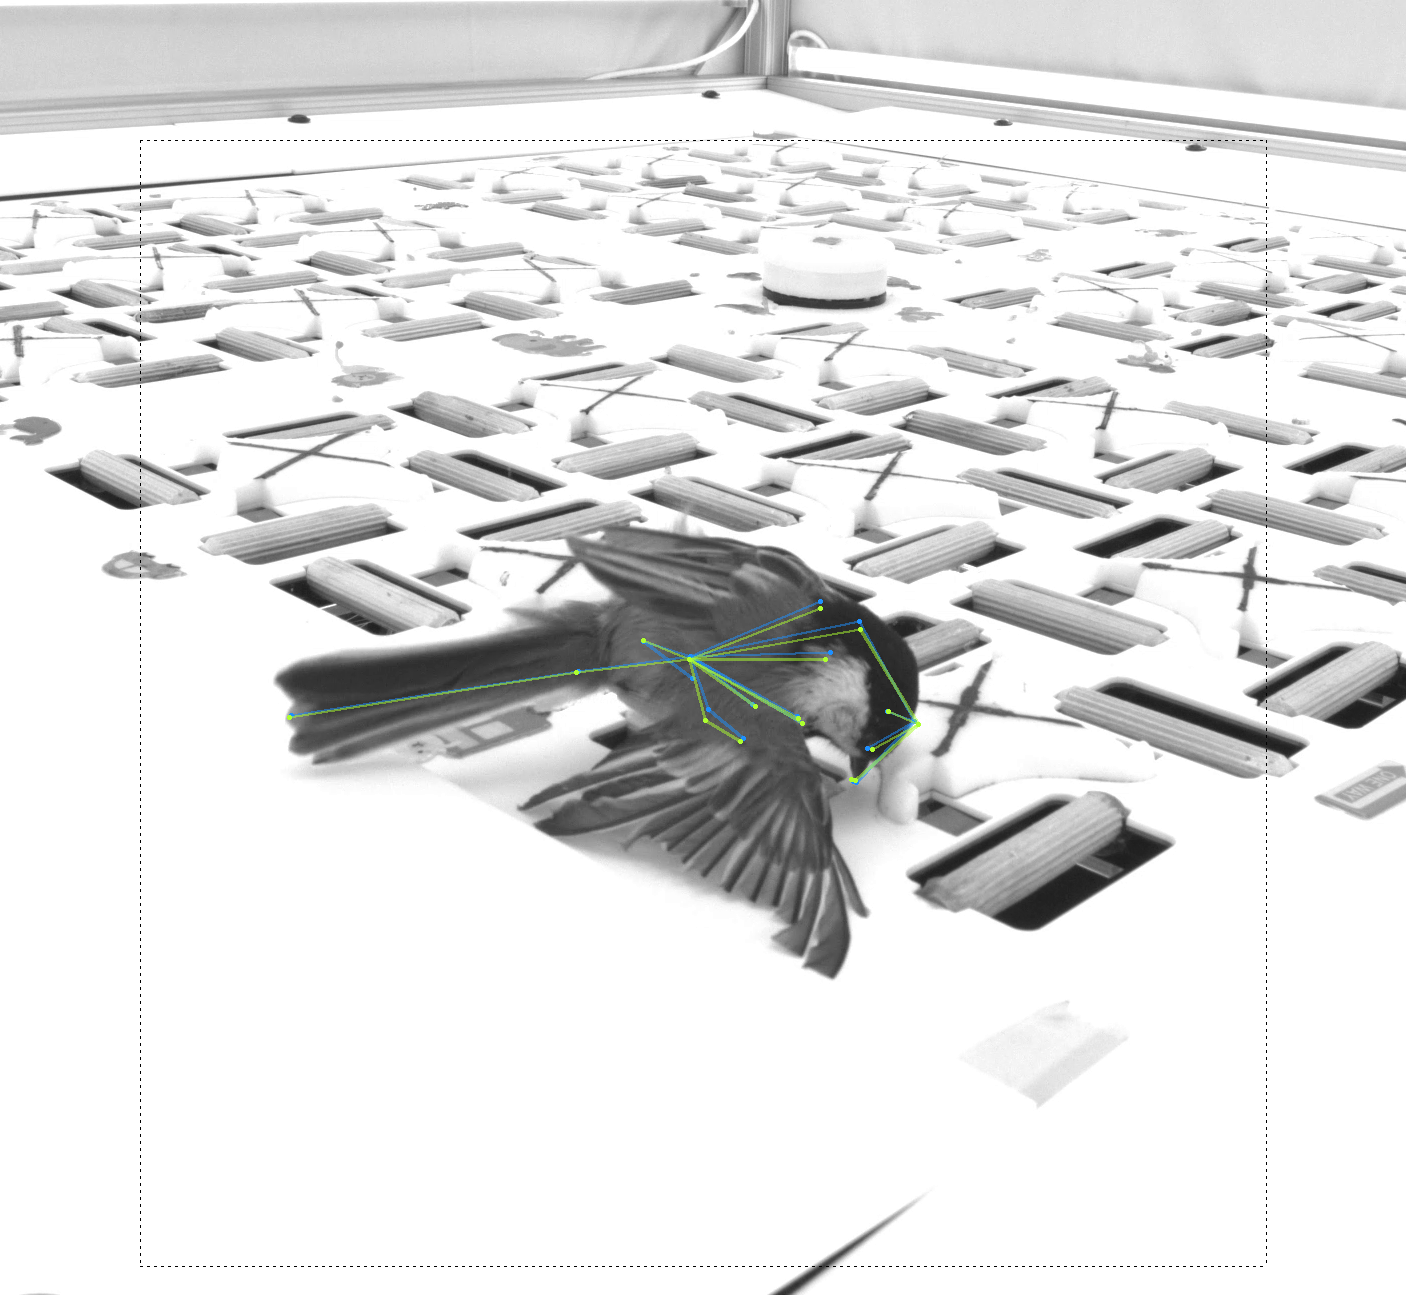

In [33]:
data_dir = "/mnt/d/LightningPoseData/chickadee"

def read_preds_file(preds_file):
    preds_df = pd.read_csv(preds_file, header=[0, 1, 2], index_col=0)
    preds_df = preds_df.droplevel(level=0, axis=1)  # axis=1 for columns
    preds_df = preds_df.loc[
        :, preds_df.columns.get_level_values(1).isin(["x", "y", "likelihood"])
    ]
    return preds_df



def draw_bbox(img, bbox):
    draw = ImageDraw.Draw(img)
    x0, y0, x1, y1 = bbox.x, bbox.y, bbox.x + bbox.w, bbox.y + bbox.h

    color = "black"
    dot_spacing = 5
    dot_length = 2

    # Clip bbox to image boundaries
    x0 = max(0, x0)
    y0 = max(0, y0)
    x1 = min(img.width, x1)
    y1 = min(img.height, y1)

    # Draw top and bottom lines
    for x in range(x0, x1, dot_spacing + dot_length):
        draw.line(
            [(x, y0), (min(x + dot_length, x1), y0)], fill=color
        )  # min to prevent going over the limit
        draw.line([(x, y1), (min(x + dot_length, x1), y1)], fill=color)

    # Draw left and right lines
    for y in range(y0, y1, dot_spacing + dot_length):
        draw.line([(x0, y), (x0, min(y + dot_length, y1))], fill=color)
        draw.line([(x1, y), (x1, min(y + dot_length, y1))], fill=color)

    padding = int(bbox.w * 0.125)
    x0_pad = max(0, x0 - padding)
    y0_pad = max(0, y0 - padding)
    x1_pad = min(img.width, x1 + padding)
    y1_pad = min(img.height, y1 + padding)

    return img.crop((x0_pad, y0_pad, x1_pad, y1_pad))


class Dataset:

    def read_files(dataset):
        bbox_file, labels_file, single_preds_file, pose_preds_file = (
            dataset.bbox_file,
            dataset.labels_file,
            dataset.single_preds_file,
            dataset.pose_preds_file,
        )
        dataset.bbox_df = pd.read_csv(bbox_file, header=[0], index_col=0)
        dataset.labels_df = read_preds_file(labels_file)
        dataset.single_preds_df = read_preds_file(single_preds_file)
        dataset.pose_preds_df = read_preds_file(pose_preds_file)
        assert set(dataset.single_preds_df.index) == set(dataset.pose_preds_df.index)
        assert set(dataset.bbox_df.index) == set(dataset.pose_preds_df.index)


    def generate_annotated_image(dataset, img_path, output_dir=None):
        labels_df, single_preds_df, pose_preds_df, bbox_df = dataset.labels_df, dataset.single_preds_df, dataset.pose_preds_df, dataset.bbox_df
        labels = labels_df.loc[img_path].unstack(level=1)
        labels["likelihood"] = 1.0
        red_preds = single_preds_df.loc[img_path].unstack(level=1)
        green_preds = pose_preds_df.loc[img_path].unstack(level=1)
        bbox = bbox_df.loc[img_path]

        abs_img_path = Path(data_dir) / img_path
        red_img = Image.open(abs_img_path)
        annotate_image_with_predictions(red_img, labels, 0.9, "#1E90FF")
        annotate_image_with_predictions(red_img, red_preds, 0.9, "#FF4500")
        red_img = draw_bbox(red_img, bbox)


        green_img = Image.open(abs_img_path)
        annotate_image_with_predictions(green_img, labels, 0.9, "#1E90FF")
        annotate_image_with_predictions(green_img, green_preds, 0.9, "#ADFF2F")
        green_img = draw_bbox(green_img, bbox)

        if output_dir is not None:
            red_path = output_dir / img_path.with_stem(img_path.stem + "_red")
            red_path.parent.mkdir(parents=True, exist_ok=True)
            red.save(red_path)

            green_path = output_dir / img_path.with_stem(img_path.stem + "_green")
            green_path.parent.mkdir(parents=True, exist_ok=True)
            green.save(green_path)

        return red_img, green_img


ind = Dataset()
ind.labels_file = "CollectedData_merged.csv"
ind.single_preds_file = "fuse_outputs/chickadee/single_0/image_preds/CollectedData_merged.csv/predictions.csv"
ind.pose_preds_file = "fuse_outputs/chickadee/pose_0_1.8/image_preds/cropped_CollectedData_merged.csv/remapped_predictions.csv"
ind.bbox_file = (
    "fuse_outputs/chickadee/single_0/image_preds/CollectedData_merged.csv/bbox.csv"
)
ind.read_files()

ood = Dataset()
ood.labels_file = "CollectedData_merged_new.csv"
ood.single_preds_file = "fuse_outputs/chickadee/single_0/image_preds/CollectedData_merged_new.csv/predictions.csv"
ood.pose_preds_file = "fuse_outputs/chickadee/pose_0_1.8/image_preds/cropped_CollectedData_merged_new.csv/remapped_predictions.csv"
# ood.pose_og_preds_file = "fuse_outputs/chickadee/pose_0_1.8/image_preds/cropped_CollectedData_merged_new.csv/remapped_predictions.csv"
ood.bbox_file = (
    "fuse_outputs/chickadee/single_0/image_preds/CollectedData_merged_new.csv/bbox.csv"
)
ood.read_files()
# TODO remove once done debugging.
ood.cropped_image_dir = "fuse_outputs/chickadee/single_0/cropped_images/"

# Previews
for img_path in ind.single_preds_df.sample(n=1).index:
    red, green = ind.generate_annotated_image(img_path)
    display(red)
    display(green)
for img_path in ood.single_preds_df.sample(n=1).index:
    ood.generate_annotated_image(img_path)
    display(red)
    display(green)


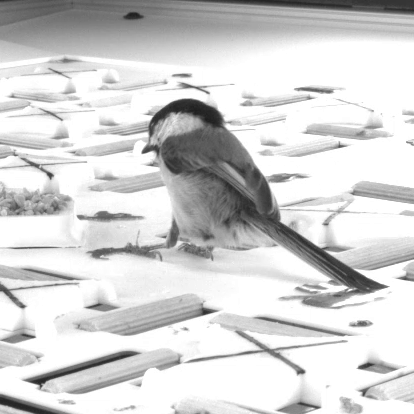

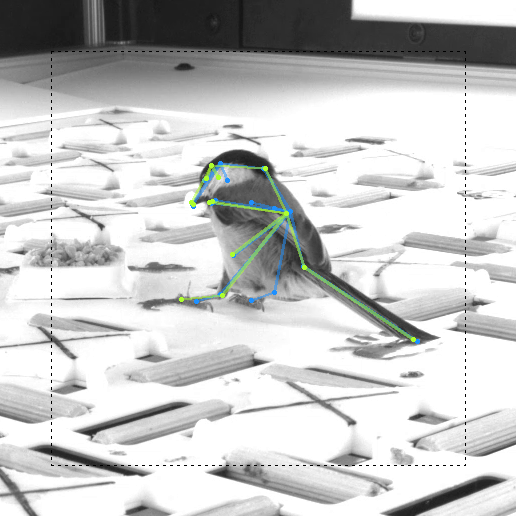

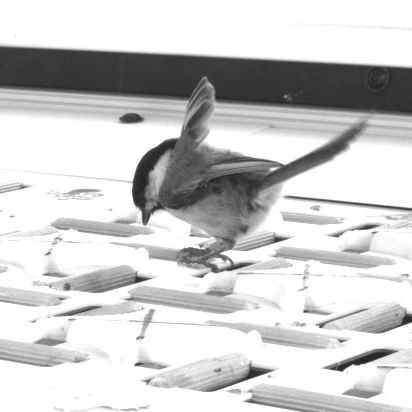

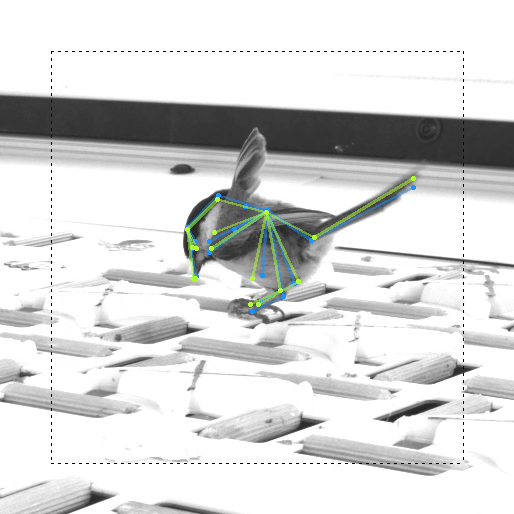

In [35]:
# bbox debugging
i = "labeled-data/SLV151_200730_131948_rBack/img00071502.png"
#print(ood.bbox_df.loc[str(Path(i).with_name("img00071501.png"))])
#print(ood.bbox_df.loc[i])
display(Image.open(Path(ood.cropped_image_dir) / i))
display(ood.generate_annotated_image(i)[1])

test_bbox = ood.bbox_df.loc[[
    "labeled-data/SLV151_200730_131948_rBack/img00071501.png",
    "labeled-data/SLV151_200730_131948_rBack/img00071502.png"
]]

"""Debug crop
import lightning_pose.utils.cropzoom
import importlib
importlib.reload(lightning_pose.utils.cropzoom)

def print_args(*args):
    print(args[:2])
    print("\n")

lightning_pose.utils.cropzoom._crop_image = print_args

lightning_pose.utils.cropzoom._crop_images(test_bbox, Path(data_dir), Path("/tmp/cz_unittest"))
"""



"""Compare with working example:"""
i = "labeled-data/SLV151_200730_131948_rBack/img00150762.png"
display(Image.open(Path(ood.cropped_image_dir) / i))
display(ood.generate_annotated_image(i)[1])


In [ ]:
"""
NOT SURE IF MULTIPROCESSING WORKS FROM JUPYTER!!!

I ran this as a separate python script.

$ jupyter nbconvert --to script cropped_predictions.ipynb

comment out the `display` calls in previous cells
"""


output_dir = Path("fuse_outputs/draw_data_dir/ind")

from tqdm import tqdm
from multiprocessing import Pool

pool = Pool()

for img_path in tqdm(ind.single_preds_df.sample(n=200).index):
    img_path = Path(img_path)
    pool.apply_async(ind.generate_annotated_image, (str(img_path), output_dir))


output_dir = Path("fuse_outputs/draw_data_dir/ood")

for img_path in tqdm(ood.single_preds_df.sample(n=200).index):
    img_path = Path(img_path)
    pool.apply_async(ood.generate_annotated_image, (str(img_path), output_dir))

pool.close()
pool.join()

In [118]:
import os
output_dir = Path("fuse_outputs/draw_data_dir")

def create_image_gallery_html(image_dir, parent_dir=None):
  """
  Creates an HTML file that displays images from a directory and links to subfolders.

  Args:
    image_dir: Path to the directory containing images.
    parent_dir: Path to the parent directory (used for creating links to subfolders).
  """

  html = """
  <!DOCTYPE html>
  <html>
  <head>
  <title>Image Gallery</title>
  <style>
  .img-container {
      display: inline-block;
      margin: 10px;
      width: 50%; /* Make images take up 50% of the container width */
      box-sizing: border-box; /* Include padding and border in the element's total width and height */
    }
    img {
      width: 100%;
      height: auto;
    }
  .pair-container {
      display: flex;
      align-items: center;
      width: 100%; /* Make pair containers take up full width */
      max-width: 1200px;
    }
  </style>
  </head>
  <body>
  <h1>Image Gallery</h1>
  """

  if parent_dir:
    html += f'<p><a href="../index.html">Parent Directory</a></p>'

  # List subfolders
  subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]
  if subfolders:
    html += '<h2>Subfolders</h2><ul>'
    for subfolder in subfolders:
      html += f'<li><a href="{subfolder}/index.html">{subfolder}</a></li>'
    html += '</ul>'

  html += '<div class="gallery">'

  # List images
  # Identify and pair red and green images
  image_pairs = {}
  for filename in os.listdir(image_dir):
    if filename.endswith(('_red.png', '_green.png')):
      # Extract root name (without _red or _green)
      root_name = filename.replace('_red.png', '').replace('_green.png', '')
      if root_name not in image_pairs:
        image_pairs[root_name] = {}
      if filename.endswith('_red.png'):
        image_pairs[root_name]['red'] = filename
      else:
        image_pairs[root_name]['green'] = filename

  # Display paired images
  for root_name, pair in image_pairs.items():
    if 'red' in pair and 'green' in pair:
      html += f"""
      <div class="pair-container">
        <div class="img-container"><img src="{pair['red']}" alt="{root_name}_red"></div>
        <div class="img-container"><img src="{pair['green']}" alt="{root_name}_green"></div>
      </div>
      """

  html += """
  </div>
  </body>
  </html>
  """

  with open(os.path.join(image_dir, 'index.html'), 'w') as f:
    f.write(html)

  # Recursively create HTML for subfolders
  for subfolder in subfolders:
    create_image_gallery_html(os.path.join(image_dir, subfolder), image_dir)

create_image_gallery_html(output_dir)